# Fuction

In [242]:
import pandas as pd
#import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('words')
from nltk.corpus import words
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import gensim
from gensim.models import Word2Vec
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
#from wordcloud import WordCloud
from nltk.probability import FreqDist
import xgboost as XGB
import random
random.seed(5)
np.random.seed(5)


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [243]:
normdic = dict()

def log_scale(df,name):
    df[name] =  np.log(df[[name]].replace(0, 0.01))
    return df
def normalize(df,name_list):
    for name in name_list:
        df = log_scale(df,name)
        # if(train==1):
        normdic[name]=[df[name].mean(),df[name].std()]
        df[name] = (df[name]-df[name].mean())/df[name].std()
        # else:
        #     df[name] = (df[name]-normdic[name][0])/normdic[name][1]
    return df
#def drop_outlier(df,name):
#     Q1 = df[name].quantile(0.25)
#     Q3 = df[name].quantile(0.75)
#     IQR = Q3 - Q1
#     lower = Q1 - 1.5*IQR
#     upper = Q3 + 1.5*IQR
#     upper_array = np.where(df[name] >= upper)[0]
#     lower_array = np.where(df[name] <= lower)[0]
#     df.drop(index=upper_array, axis='index',inplace=True)
#     df.drop(index=lower_array, axis='index', inplace=True)
#     return df

In [244]:
def dataclean (df,train):
    #drop unnessesary columns
    df.drop(['no','APP_date','date_of_birth_week','APP_Area','APP_Province','APP_Shop Name','tel_category','postal_code','c_postal_code','c_salary_payment_methods','media','r_generalcode1','r_generalcode2','apply'],axis=1,inplace=True)
    #recal age
    df[['year','month','date']] = df['date_of_birth'].str.split('/', 2, expand = True)
    df.drop(['date_of_birth'],axis=1,inplace=True)
    df['age'] = (2023 - df['year'].astype(int))
    df.drop(['month'],axis=1,inplace=True)
    df.drop(['date'],axis=1,inplace=True)    
    df.drop(['year'],axis=1,inplace=True)
    df['living_all'] = df['living_period_year']*12+df['living_period_month']
    df.drop(['living_period_year'],axis=1,inplace=True)
    df.drop(['living_period_month'],axis=1,inplace=True)
    #recal working period
    df['Number_of_working'] = df['c_number_of_working_year']*12+df['c_number_of_working_month']
    df.drop(['c_number_of_working_year'],axis=1,inplace=True)
    df.drop(['c_number_of_working_month'],axis=1,inplace=True)
    #fillna
    df['r_expected_credit_limit'].fillna(df['r_expected_credit_limit'].mean(), inplace=True)
    df['r_additional_income'].fillna(df['r_additional_income'].mean(), inplace=True)
    df['r_spouse_income'].fillna(df['r_spouse_income'].mean(), inplace=True)
    df['c_date_of_salary_payment'].fillna(df['c_date_of_salary_payment'].median(), inplace=True)
    df['r_generalcode3'].fillna(4, inplace=True)
    df['r_propose'].fillna(6, inplace=True)
    #if(train ==1):
    #    outlier_list=['number_of_children','number_of_resident','c_monthly_salary','r_expected_credit_limit','r_allloan_amount','c_number_of_employee','r_allloan_case','r_additional_income','r_spouse_income']
    #    for i in outlier_list:
    #        print(i)
    #        df = drop_outlier(df,i)        
    #normalize
    normlist =['c_monthly_salary','r_expected_credit_limit','r_allloan_amount','c_number_of_employee','r_allloan_case','r_additional_income','r_spouse_income']
    df = normalize(df,normlist)
    #get dummie
    col_gender = pd.get_dummies(df['gender'], dtype = int)
    df.drop(['gender'],axis=1,inplace=True)
    df = pd.concat([df,col_gender], axis = 1)
    #df['apply'] = df['apply'].replace(['DS','LB','OT','SB','WI'],[1,3,2,2,1])
    #
    #df['day_range'] = df['PostDate'].dt.day.apply(lambda x: 0 if x <= 10 else (1 if x <= 20 else 2))
    #df
    #adding has fico,
    df.insert(len(df.columns), 'HasFico', 0)
    df['HasFico'] = np.where(df['FICO_Score']!= 0, 1, 0)
    df.insert(len(df.columns), 'HasSpouse', 0)
    df['HasSpouse'] = np.where(df['marital_status']== 2, 1, 0)    
    return df

# Train data

In [245]:
your_traindata_name = 'your_traindata_name.csv'
df=pd.read_csv(your_traindata_name)
df

,no,APP_date,APP_Area,APP_Province,APP_Shop Name,gender,date_of_birth_week,date_of_birth,marital_status,number_of_children,...,r_allloan_case,r_allloan_amount,r_additional_income,r_spouse_income,r_generalcode1,r_generalcode2,r_generalcode3,apply,FICO_Score,default_12month
0,8000001,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F1,1,1967/1/22,2,2,...,0.0,0,0.0,30000.0,1.0,6.0,1.0,WI,0,0
1,8000002,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,2,1972/9/11,3,2,...,1.0,40000,0.0,0.0,NaN,NaN,1.0,DS,664,0
2,8000003,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1971/5/18,1,2,...,0.0,0,0.0,0.0,NaN,NaN,2.0,WI,630,0
3,8000004,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1983/1/5,1,0,...,0.0,0,5000.0,0.0,NaN,NaN,1.0,WI,0,0
4,8000005,2018/4/3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1985/9/13,1,0,...,0.0,0,0.0,0.0,NaN,NaN,1.0,WI,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56312,8086062,2018/8/31,webpak,webpak,webpak,M,2,1992/5/11,1,0,...,0.0,0,NaN,NaN,NaN,NaN,NaN,OT,598,0
56313,8086063,2018/8/31,webpak,webpak,webpak,M,6,1992/4/10,1,0,...,0.0,0,0.0,0.0,NaN,NaN,NaN,OT,594,0
56314,8086064,2018/8/31,webpak,webpak,webpak,F2,5,1984/12/27,1,0,...,0.0,0,0.0,0.0,NaN,NaN,NaN,OT,731,0
56315,8086065,2018/8/31,webpak,webpak,webpak,M,2,1989/6/12,1,0,...,0.0,0,0.0,0.0,NaN,NaN,NaN,OT,653,0


# Histrogram

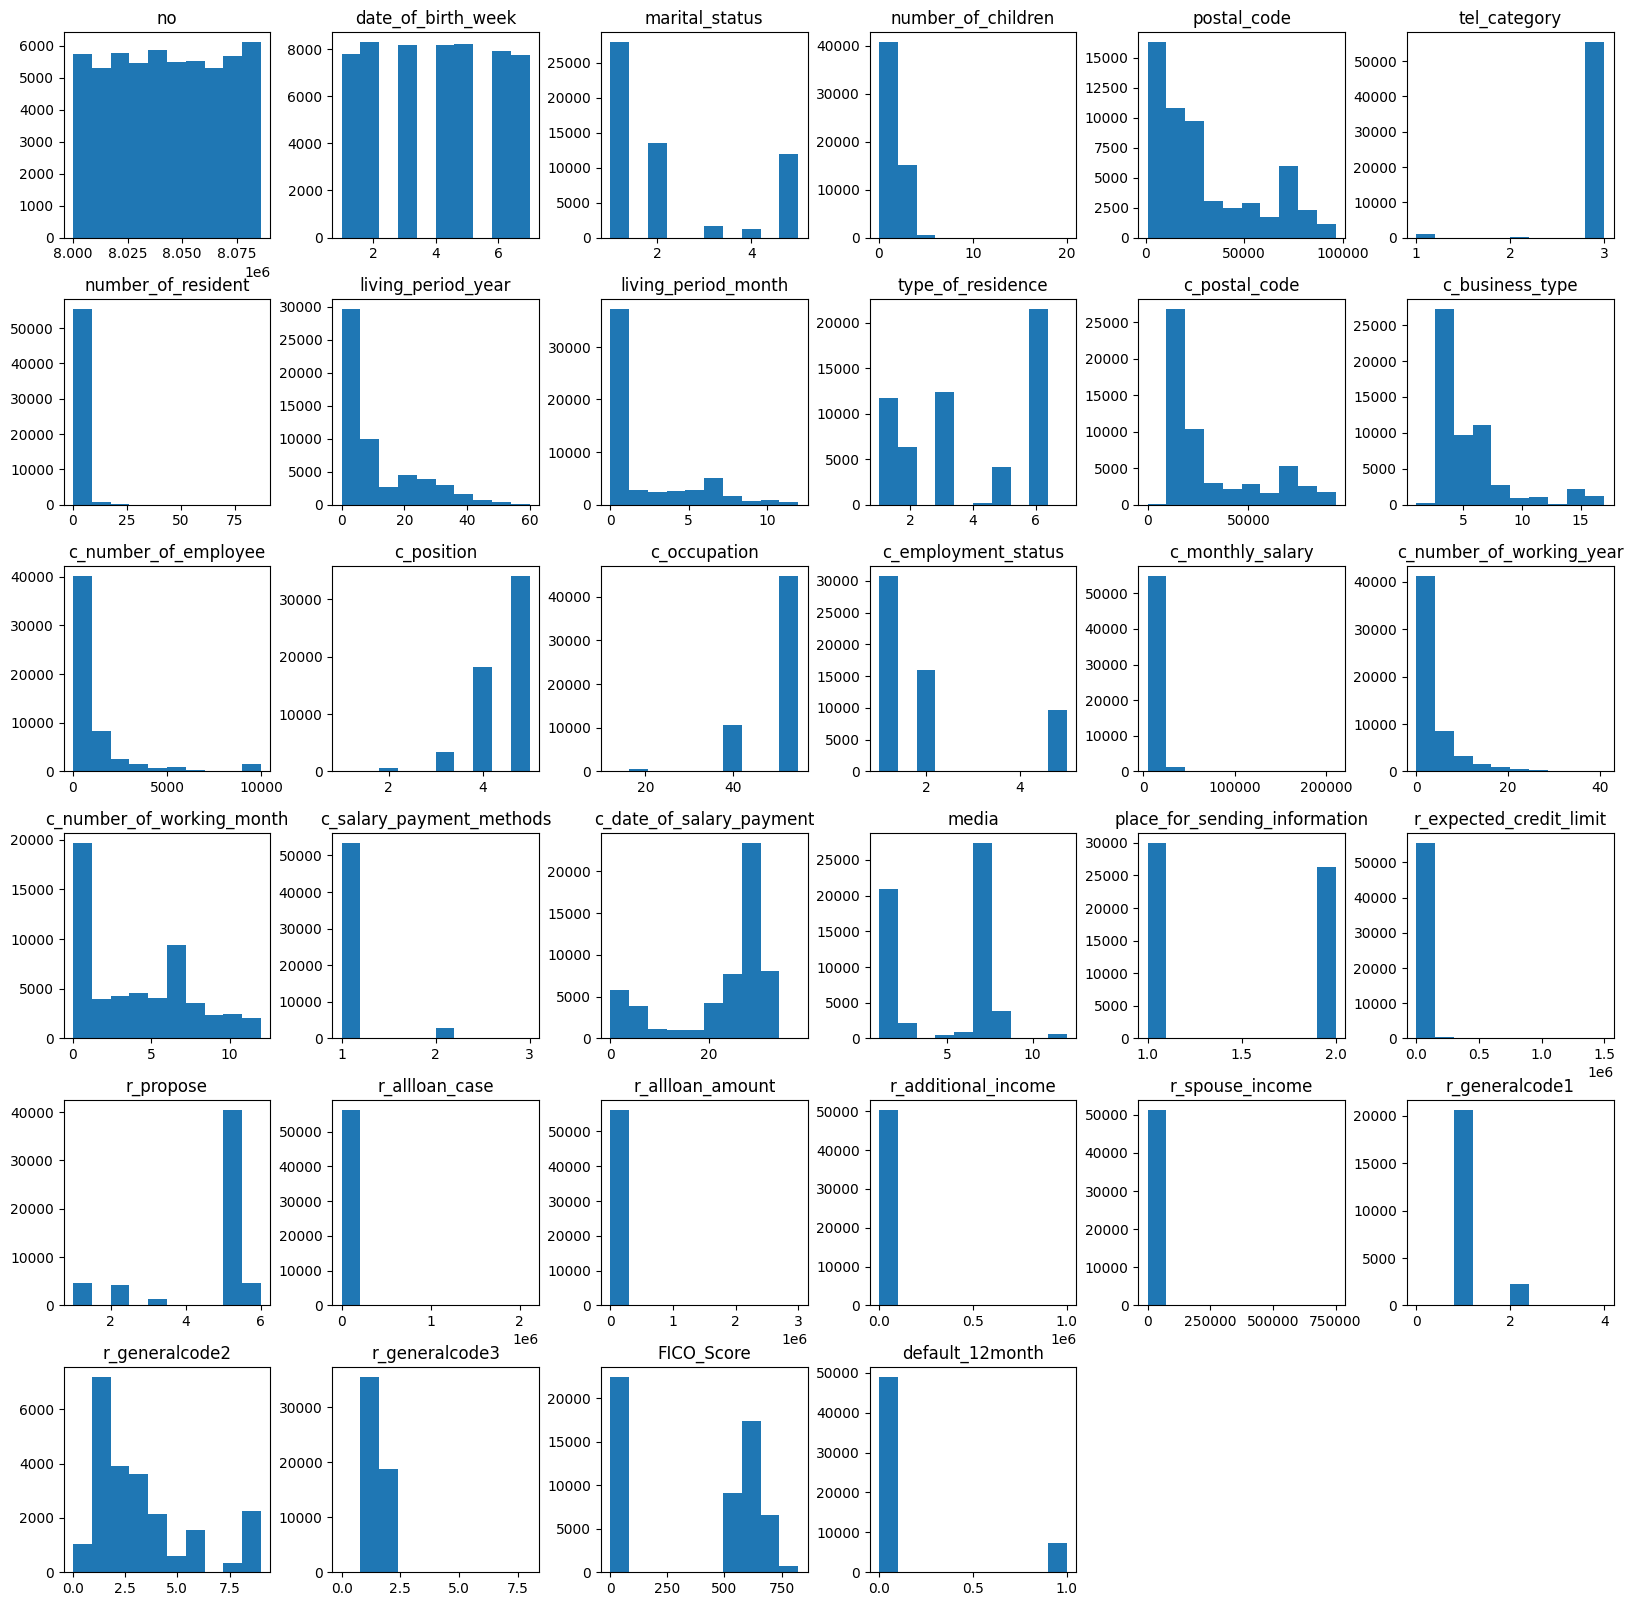

In [246]:
df.hist(bins=10,figsize=(20,20),grid=False);

# Data cleaning

In [247]:
df=dataclean (df,1)
df

,marital_status,number_of_children,number_of_resident,type_of_residence,c_business_type,c_number_of_employee,c_position,c_occupation,c_employment_status,c_monthly_salary,...,FICO_Score,default_12month,age,living_all,Number_of_working,F1,F2,M,HasFico,HasSpouse
0,2,2,6,1,7,0.758985,5,55,5,-1.095380,...,0,0,56,120,7,1,0,0,0,1
1,3,2,2,6,7,-1.676129,5,55,5,-0.682438,...,664,0,51,60,138,0,0,1,1,0
2,1,2,2,6,7,2.094034,5,55,5,-0.665781,...,630,0,52,60,60,0,1,0,1,0
3,1,0,3,6,7,0.357077,5,55,5,0.087910,...,0,0,40,48,64,0,0,1,0,0
4,1,0,5,5,12,0.357077,4,40,1,1.727842,...,0,0,38,27,18,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56312,1,0,2,6,4,1.395993,5,54,1,-0.649854,...,598,0,31,24,8,0,0,1,1,0
56313,1,0,2,2,4,-0.341022,5,54,1,0.145207,...,594,0,31,14,18,0,0,1,1,0
56314,1,0,2,2,7,1.160892,5,54,5,0.815902,...,731,0,39,8,8,0,1,0,1,0
56315,1,0,2,2,4,0.357077,5,54,1,0.862827,...,653,0,34,30,7,0,0,1,1,0


In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56317 entries, 0 to 56316
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   marital_status                 56317 non-null  int64  
 1   number_of_children             56317 non-null  int64  
 2   number_of_resident             56317 non-null  int64  
 3   type_of_residence              56317 non-null  int64  
 4   c_business_type                56317 non-null  int64  
 5   c_number_of_employee           56317 non-null  float64
 6   c_position                     56317 non-null  int64  
 7   c_occupation                   56317 non-null  int64  
 8   c_employment_status            56317 non-null  int64  
 9   c_monthly_salary               56317 non-null  float64
 10  c_date_of_salary_payment       56317 non-null  float64
 11  place_for_sending_information  56317 non-null  int64  
 12  r_expected_credit_limit        56317 non-null 

# Test data

In [249]:
your_testdata_name = 'your_testdata_name.csv'
df2=pd.read_csv(your_testdata_name)
no = df2["no"]
df2=dataclean (df2,0)

In [250]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474 entries, 0 to 9473
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   marital_status                 9474 non-null   int64  
 1   number_of_children             9474 non-null   int64  
 2   number_of_resident             9474 non-null   int64  
 3   type_of_residence              9474 non-null   int64  
 4   c_business_type                9474 non-null   int64  
 5   c_number_of_employee           9474 non-null   float64
 6   c_position                     9474 non-null   int64  
 7   c_occupation                   9474 non-null   int64  
 8   c_employment_status            9474 non-null   int64  
 9   c_monthly_salary               9474 non-null   float64
 10  c_date_of_salary_payment       9474 non-null   float64
 11  place_for_sending_information  9474 non-null   int64  
 12  r_expected_credit_limit        9474 non-null   f

# Traindata

In [251]:
y = df['default_12month'].values
df =df.drop('default_12month',axis=1)
X=df.values



## XGBOOST

In [252]:
xgb = XGB.XGBClassifier()
xgb.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [253]:
X2=df2.values
x_y_pred = xgb.predict(X2)

In [254]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# AUC (Test)
x_y_pred = xgb.predict_proba(X2)[:, 1]


In [255]:
#import pandas as pd
#CSV = pd.DataFrame({
#    "no": no,
#    "default_12month": x_y_pred
#})

#CSV.to_csv("output.csv", index=False)

## GridSearchCV with XGBoost

In [256]:
#try different parameter values
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
param_grid_x = {
    'max_depth': [2,3,5,10],
    'n_estimators': [60,100,120],
    'reg_lambda' :[1,5],
    'subsample'	: [0.5,1],
    'colsample_bytree'	:[0.5,0.75,1]
}

In [257]:
x_grid = GridSearchCV(
    estimator = xgb,
    param_grid = param_grid_x,
    scoring="roc_auc",
    refit = True,
    cv = 5,
    n_jobs = -1
)

In [258]:
x_grid.fit(X,y)
print(x_grid.best_params_)
print(x_grid.best_score_)
x_grid_y_pred = x_grid.predict_proba(X2)[:, 1]

{'colsample_bytree': 1, 'max_depth': 2, 'n_estimators': 120, 'reg_lambda': 5, 'subsample': 1}
0.6519325052856149


In [259]:
import pandas as pd
CSV = pd.DataFrame({
    "no": no,
    "default_12month": x_grid_y_pred
})

CSV.to_csv("EExAI private 2.csv", index=False)